In [7]:
from google.colab import drive
drive.mount('/drive')
%cd /drive

Mounted at /drive
/drive


In [4]:
import os

os.chdir('/content/drive/MyDrive/Duygu_Tanima')

In [5]:
!ls 

 CinsiyetTanima.ipynb	   DuyguTanima_Demo2.ipynb   DuyguTanima.ipynb
 data			   DuyguTanima_Demo3.ipynb   images
 DuyguTanima_Demo1.ipynb  'Duygu Tanıma Demo.PNG'    utils


In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

In [7]:
root = '/content/drive/MyDrive/Duygu_Tanima'

data = pd.read_csv(root +  '/data/fer2013/fer2013.csv')
data.shape

(35887, 3)

In [8]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [10]:
np.unique(data["Usage"].values.ravel())

print('Eğitim setindeki örnek sayısı: %d'%(len(data[data.Usage == "Training"])))

Eğitim setindeki örnek sayısı: 28709


In [11]:
train_data = data [data.Usage == "Training"]

In [12]:
train_pixels = train_data.pixels.str.split(" ").tolist() 

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)

print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [13]:
def show(img):
    show_image = img.reshape(48,48)
    
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

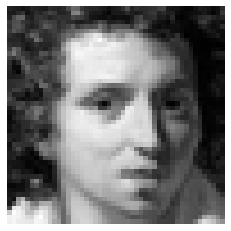

In [14]:
show(train_images[1000])

In [15]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


In [16]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [17]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)

y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


In [19]:
np.unique(data["Usage"].values.ravel()) 

print('Test verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "PublicTest"])))

Test verisetindeki örnek sayısı: 3589


In [20]:
test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)



(3589, 2304)


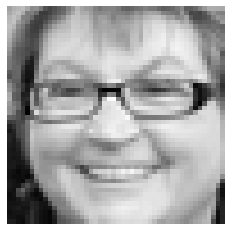

In [21]:
show(test_images[100])

In [22]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


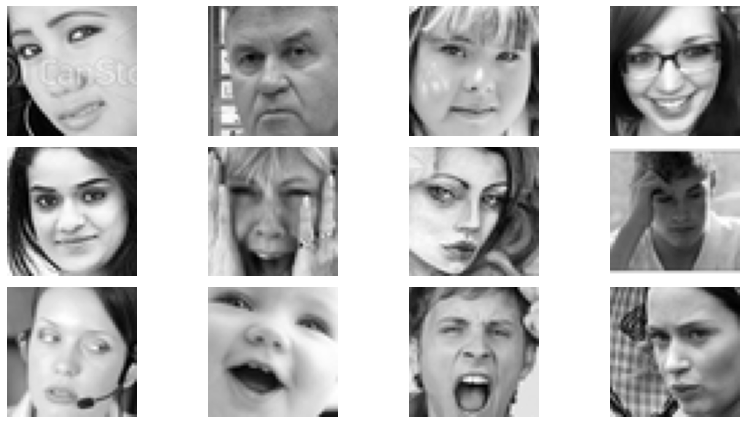

In [23]:

plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3, 4, i)
  plt.axis('off')

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

In [24]:
model = Sequential()

#1. KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2. KATMAN

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### 3. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


### 4. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 5. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))#%60 unutma işlemi(nöron silme-dropout)

### Çıkış katmanı

model.add(Dense(7))
model.add(Activation('softmax')) #Sınıflama işlemi (7 duygu sınıfı var)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0

In [25]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print('Train:', x_train.shape)
print('Test:', x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [26]:
print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


In [27]:

checkpointer = ModelCheckpoint(filepath=root + 'data/face_model.h5', verbose=1, save_best_only=True)

epochs = 10
batchSize = 100



hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)
                

model_json = model.to_json()
with open(root + 'data/face_model.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/10
288/288 - 50s - loss: 1.9989 - accuracy: 0.2582 - val_loss: 1.5830 - val_accuracy: 0.3998

Epoch 00001: val_loss improved from inf to 1.58298, saving model to /content/drive/MyDrive/Duygu_Tanimadata/face_model.h5
Epoch 2/10
288/288 - 16s - loss: 1.6444 - accuracy: 0.3529 - val_loss: 1.4776 - val_accuracy: 0.4280

Epoch 00002: val_loss improved from 1.58298 to 1.47760, saving model to /content/drive/MyDrive/Duygu_Tanimadata/face_model.h5
Epoch 3/10
288/288 - 16s - loss: 1.5340 - accuracy: 0.4040 - val_loss: 1.4280 - val_accuracy: 0.4402

Epoch 00003: val_loss improved from 1.47760 to 1.42799, saving model to /content/drive/MyDrive/Duygu_Tanimadata/face_model.h5
Epoch 4/10
288/288 - 16s - loss: 1.4549 - accuracy: 0.4371 - val_loss: 1.3607 - val_accuracy: 0.4759

Epoch 00004: val_loss improved from 1.42799 to 1.36072, saving model to /content/drive/MyDrive/Duygu_Tanimadata/face_model.h5
Epoch 5/10
288/288 - 16s - loss: 1.4162 - accuracy: 0.4564 - val_loss: 1.3344 - val_accuracy

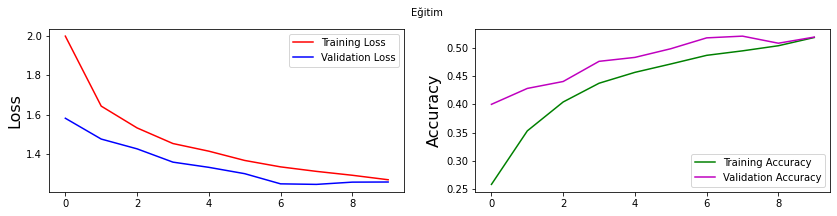

In [29]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()


In [30]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [31]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [32]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [33]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu:", score)

PrivateTest üzerindeki doğruluk durumu: [1.2425692081451416, 0.5171356797218323]


In [34]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

In [35]:

model_best = load_model(root + 'data/face_model.h5')


In [36]:
os.chdir('/content/drive/MyDrive/Duygu_Tanima/images')

In [37]:
!ls

bb1.jpg     hababam.jpg        kemal_sunal.jpg	robertdeniro.jpg  test5.jpg
bb2.jpg     javierbardem2.jpg  lotr1.png	test2.jpg	  test6.jpg
brando.png  javierbardem.jpg   lotr2.jpg	test3.jpg	  test.jpg
emojis	    kemal_sunal2.jpg   lotr3.jpg	test4.jpg


In [43]:


image_path = root + "/images/kemal_sunal.jpg"

test_image_original = image.load_img(image_path) 

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([[0.06984887, 0.00171472, 0.04931081, 0.3007023 , 0.12214452,
        0.03180128, 0.4244775 ]], dtype=float32)

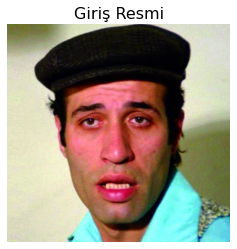

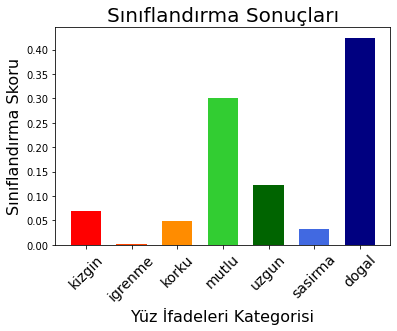

Sınıflandırma sonucu en yüksek oranla: dogal


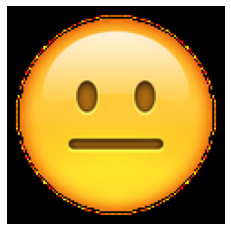

In [44]:

class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasirma', 'dogal']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4  #bar genişliği

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']


plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()


for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel("Yüz İfadeleri Kategorisi",fontsize=16)
plt.ylabel("Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])


emojis_img = image.load_img(root + '/images/emojis/%s.png'% str(class_names[np.argmax(results)]))

plt.imshow(emojis_img)
plt.axis('off')
plt.show()
